<a id = '0'></a>
<h2 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: black; color : white; border-radius: 5px 5px; text-align:center; font-weight: bold" >Table of Contents</h2> 

1. [Overview](#1.0)
2. [Study the data](#2.0)
3. [Data Cleaning](#3.0)
4. [Feature Extraction](#4.0)
5. [Model Building](#5.0)
      - [Multinomial Naive Bayes Model](#5.1)
      - [Logistic Regression](#5.2)
      - [SVM](#5.3)
6. [Export Model](#6.0)      
7. [Conclusion](#7.0)
8. [Appendix](#8.0)


<a id = '1.0'></a>
<h2 style = "font-size:35px; font-family:Garamond ; font-weight : normal; background-color: black; color : white; text-align: center; border-radius: 5px 5px; padding: 5px"> 1. Overview </h2> 

### Topic Clarity:

In this project, the goal is to build a hotel review sentiment analysis where it will classify the user's review to positive or negative. 

### Dataset Selection:

This dataset contains 20492 hotel reviews with the rating. This dataset is taken from 'Kaggle'. This dataset was choosen to train the model is because the dataset is large.

<a id = '2.0'></a>
<h2 style = "font-size:35px; font-family:Garamond ; font-weight : normal; background-color: black; color : white; text-align: center; border-radius: 5px 5px; padding: 5px"> 2. Study the data </h2> 

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

df = pd.read_csv('/Users/wongyenchik/Desktop/NLP/tripadvisor_hotel_reviews.csv')
df.head()

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


In [2]:
df.shape


(20491, 2)

### There are 20491 row and 2 column

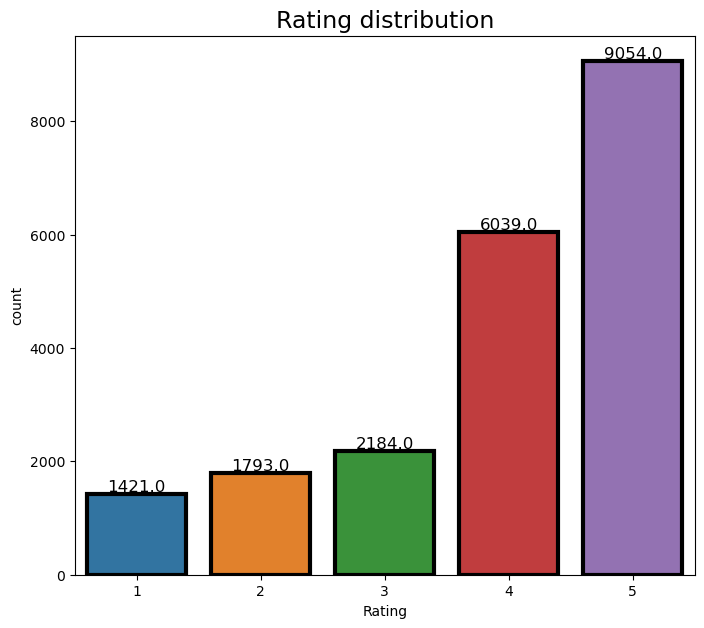

In [3]:
plt.figure(figsize=(8, 7))
ax = sns.countplot(data=df, x="Rating", edgecolor='black', linewidth=3)

# Annotate the bars with their counts
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height}', (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom', fontsize=12, color='black')

plt.title('Rating distribution', size=17)
plt.show()


### We observe the data is left skewed



In [4]:
df.dtypes

Review    object
Rating     int64
dtype: object

In [5]:
df.isna().sum()


Review    0
Rating    0
dtype: int64

### There is no null value

In [6]:
#Label rating that got higher than 2 as positive review
def rating(score):
    if score > 2:
        return 'Positive'
    else:
        return 'Negative'

In [7]:
df['Rating'] = df['Rating'].apply(rating)
df.head()

,Review,Rating
0,nice hotel expensive parking got good deal sta...,Positive
1,ok nothing special charge diamond member hilto...,Negative
2,nice rooms not 4* experience hotel monaco seat...,Positive
3,"unique, great stay, wonderful time hotel monac...",Positive
4,"great stay great stay, went seahawk game aweso...",Positive


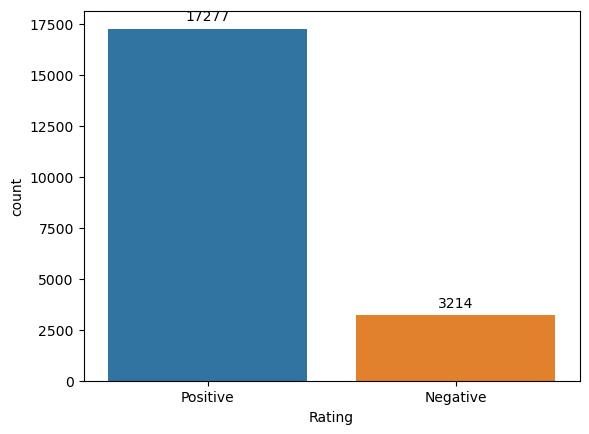

In [8]:
# Create the countplot
ax = sns.countplot(x=df['Rating'])

# Annotate each bar with its count value
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 9), 
                textcoords = 'offset points')

# Show the plot
plt.show()


### Majority of the dataset is positive

<a id = '3.0'></a>
<h2 style = "font-size:35px; font-family:Garamond ; font-weight : normal; background-color: black; color : white; text-align: center; border-radius: 5px 5px; padding: 5px"> 3. Data Cleaning </h2> 

In [9]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from string import punctuation
from nltk.stem import WordNetLemmatizer

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/wongyenchik/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/wongyenchik/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/wongyenchik/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [10]:
def clean_text(text):
    #Stopword such as 'and', 'the' are store in stop variable
    stop = set(stopwords.words('english'))
    #Punctuation such as . , are store in punc variable
    punc = set(punctuation)
    #Create an instance for the WordNetLemmatizer class from the NLTK library
    lemma = WordNetLemmatizer()
    #Tokenination to splitting text into individual words or tokens.
    tokens = word_tokenize(text)
    #Filter out non-alphabetic characters
    word_tokens = [t for t in tokens if t.isalpha()]
    #Lowercase and lemmatize words that are not in the union of two set :stop and punc 
    clean_tokens = [lemma.lemmatize(t.lower()) for t in word_tokens if t not in stop.union(punc)]
    # Join the cleaned tokens into a single string
    cleaned_text = ' '.join(clean_tokens)
    return cleaned_text


In [11]:
df['Review'] = df['Review'].apply(clean_text)

In [12]:
df.head(10)

,Review,Rating
0,nice hotel expensive parking got good deal sta...,Positive
1,ok nothing special charge diamond member hilto...,Negative
2,nice room experience hotel monaco seattle good...,Positive
3,unique great stay wonderful time hotel monaco ...,Positive
4,great stay great stay went seahawk game awesom...,Positive
5,love monaco staff husband stayed hotel crazy w...,Positive
6,cozy stay rainy city husband spent night monac...,Positive
7,excellent staff housekeeping quality hotel cho...,Positive
8,hotel stayed hotel monaco cruise room generous...,Positive
9,excellent stayed hotel monaco past delight rec...,Positive


<a id = '4.0'></a>
<h2 style = "font-size:35px; font-family:Garamond ; font-weight : normal; background-color: black; color : white; text-align: center; border-radius: 5px 5px; padding: 5px"> 4. Feature Extraction </h2> 

In [13]:
x = df['Review']
y = df['Rating']

In [14]:
# Split Text train set to 80-20
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=35)
print('X_train: ', len(X_train))
print('X_test: ', len(X_test))
print('y_train: ', len(y_train))
print('y_test: ', len(y_test))

X_train:  16392
X_test:  4099
y_train:  16392
y_test:  4099


In [15]:
#TF-IDF vector encodes the importance of words
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
vectorizer = TfidfVectorizer()

In [16]:
#LabelEncoder is used to convert categorical class labels into numerical labels
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(y)


<a id = '5.0'></a>
<h2 style = "font-size:35px; font-family:Garamond ; font-weight : normal; background-color: black; color : white; text-align: center; border-radius: 5px 5px; padding: 5px"> 5. Model Building </h2> 

<a id = '5.1'></a>
## Multinomial Naive Bayes Model



In [17]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
# Create a Naive Bayes classifier (Multinomial Naive Bayes is suitable for text classification)
naive_bayes_classifier = MultinomialNB()

model = Pipeline([('vectorizer', vectorizer),('classifier', naive_bayes_classifier)])
# Train the classifier using the training data
model.fit(X_train, y_train)

Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                ('classifier', MultinomialNB())])

In [18]:
from sklearn.metrics import confusion_matrix
predictions = model.predict(X_test)
confusion_matrix(predictions, y_test)

array([[   1,    0],
       [ 627, 3471]])

In [19]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

print("Accuracy: ", accuracy_score(predictions, y_test))
print("Precision: ", precision_score(predictions, y_test, average = 'weighted'))
print("Recall: ", recall_score(predictions, y_test, average = 'weighted'))


Accuracy:  0.8470358624054648
Precision:  0.9997564265324927
Recall:  0.8470358624054648


In [20]:
print("Train Score: ", model.score(X_train, y_train))
print("Test Score: ", model.score(X_test, y_test))

Train Score:  0.8452293801854563
Test Score:  0.8470358624054648


## Multinomial Naive Bayes Model Testing

In [21]:
example = ["I don't like this hotel"]

def clean_text(text):
    # Stopwords such as 'and', 'the' are stored in the stop variable
    stop = set(stopwords.words('english'))
    # Punctuation such as . , are stored in the punc variable
    punc = set(punctuation)
    # Create an instance for the WordNetLemmatizer class from the NLTK library
    lemma = WordNetLemmatizer()
    # Tokenization to split text into individual words or tokens.
    tokens = word_tokenize(text)
    # Filter out non-alphabetic characters
    word_tokens = [t for t in tokens if t.isalpha()]
    # Lowercase and lemmatize words that are not in the union of two sets: stop and punc 
    clean_tokens = [lemma.lemmatize(t.lower()) for t in word_tokens if t not in stop.union(punc)]
    # Join the cleaned tokens into a single string
    cleaned_text = ' '.join(clean_tokens)
    return cleaned_text  # You need to return the cleaned text

# Use list comprehension to clean each example in the list
cleaned_examples = [clean_text(text) for text in example]

# Now you can use the cleaned examples for prediction
result = model.predict(cleaned_examples)
print(result)


['Positive']


<a id = '5.2'></a>
## Logistic Regression

In [22]:
from sklearn.linear_model import LogisticRegression
logis = LogisticRegression()

modelLogis = Pipeline([('vectorizer', vectorizer),('classifier', logis)])
# Train the classifier using the training data
modelLogis.fit(X_train, y_train)

Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                ('classifier', LogisticRegression())])

In [23]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

print("Accuracy: ", accuracy_score(predictions, y_test))
print("Precision: ", precision_score(predictions, y_test, average = 'weighted'))
print("Recall: ", recall_score(predictions, y_test, average = 'weighted'))


Accuracy:  0.8470358624054648
Precision:  0.9997564265324927
Recall:  0.8470358624054648


In [24]:
print("Train Score: ", modelLogis.score(X_train, y_train))
print("Test Score: ", modelLogis.score(X_test, y_test))

Train Score:  0.9474743777452416
Test Score:  0.9336423517931203


## Logistic Model Testing

In [25]:
example = ["They always treat you with care and love."]

def clean_text(text):
    # Stopwords such as 'and', 'the' are stored in the stop variable
    stop = set(stopwords.words('english'))
    # Punctuation such as . , are stored in the punc variable
    punc = set(punctuation)
    # Create an instance for the WordNetLemmatizer class from the NLTK library
    lemma = WordNetLemmatizer()
    # Tokenization to split text into individual words or tokens.
    tokens = word_tokenize(text)
    # Filter out non-alphabetic characters
    word_tokens = [t for t in tokens if t.isalpha()]
    # Lowercase and lemmatize words that are not in the union of two sets: stop and punc 
    clean_tokens = [lemma.lemmatize(t.lower()) for t in word_tokens if t not in stop.union(punc)]
    # Join the cleaned tokens into a single string
    cleaned_text = ' '.join(clean_tokens)
    return cleaned_text  # You need to return the cleaned text

# Use list comprehension to clean each example in the list
cleaned_examples = [clean_text(text) for text in example]

# Now you can use the cleaned examples for prediction
result = modelLogis.predict(cleaned_examples)
print(result)


['Positive']


<a id = '5.3'></a>
## SVM

In [26]:
from sklearn.svm import SVC

# Initialize the SVM classifier
svm_classifier = SVC(kernel='linear', random_state=42, probability = True)


modelSVM = Pipeline([('vectorizer', vectorizer),('classifier', svm_classifier)])
# Train the classifier using the training data
modelSVM.fit(X_train, y_train)

Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                ('classifier',
                 SVC(kernel='linear', probability=True, random_state=42))])

In [27]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

print("Accuracy: ", accuracy_score(predictions, y_test))
print("Precision: ", precision_score(predictions, y_test, average = 'weighted'))
print("Recall: ", recall_score(predictions, y_test, average = 'weighted'))


Accuracy:  0.8470358624054648
Precision:  0.9997564265324927
Recall:  0.8470358624054648


In [28]:
print("Train Score: ", modelSVM.score(X_train, y_train))
print("Test Score: ", modelSVM.score(X_test, y_test))

Train Score:  0.9742557345046364
Test Score:  0.9355940473286167


## SVM Model Testing

In [29]:
example = ["I like this hotel"]

def clean_text(text):
    # Stopwords such as 'and', 'the' are stored in the stop variable
    stop = set(stopwords.words('english'))
    # Punctuation such as . , are stored in the punc variable
    punc = set(punctuation)
    # Create an instance for the WordNetLemmatizer class from the NLTK library
    lemma = WordNetLemmatizer()
    # Tokenization to split text into individual words or tokens.
    tokens = word_tokenize(text)
    # Filter out non-alphabetic characters
    word_tokens = [t for t in tokens if t.isalpha()]
    # Lowercase and lemmatize words that are not in the union of two sets: stop and punc 
    clean_tokens = [lemma.lemmatize(t.lower()) for t in word_tokens if t not in stop.union(punc)]
    # Join the cleaned tokens into a single string
    cleaned_text = ' '.join(clean_tokens)
    return cleaned_text  # You need to return the cleaned text

# Use list comprehension to clean each example in the list
cleaned_examples = [clean_text(text) for text in example]

# Now you can use the cleaned examples for prediction
result = modelSVM.predict(cleaned_examples)
print(result)


['Negative']


### Hyperparameter Tuning
Linear - data is expected to be linearly separable in the input space.

Sigmoid - non-linear kernel that is often used in neural networks

In [31]:
svm_classifier1 = SVC(kernel='sigmoid', random_state=42, probability = True)


modelSVM1 = Pipeline([('vectorizer', vectorizer),('classifier', svm_classifier1)])
# Train the classifier using the training data
modelSVM1.fit(X_train, y_train)

Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                ('classifier',
                 SVC(kernel='sigmoid', probability=True, random_state=42))])

In [32]:
print("Train Score: ", modelSVM1.score(X_train, y_train))
print("Test Score: ", modelSVM1.score(X_test, y_test))

Train Score:  0.9586383601756955
Test Score:  0.9348621615028055


#### After changing the kernel to sigmoid, the performance is slightly worst than linear so will still remain the linear version of the model.

<a id = '6.0'></a>
<h2 style = "font-size:35px; font-family:Garamond ; font-weight : normal; background-color: black; color : white; text-align: center; border-radius: 5px 5px; padding: 5px"> 6. Export model </h2> 

In [33]:
import joblib
joblib.dump(modelSVM, 'review_detector.joblib') 


['review_detector.joblib']

In [34]:
model1 = joblib.load('review_detector.joblib')


In [35]:
example = ["Restaurants with at least 4 items missing from the menu at least three times. "]

def clean_text(text):
    # Stopwords such as 'and', 'the' are stored in the stop variable
    stop = set(stopwords.words('english'))
    # Punctuation such as . , are stored in the punc variable
    punc = set(punctuation)
    # Create an instance for the WordNetLemmatizer class from the NLTK library
    lemma = WordNetLemmatizer()
    # Tokenization to split text into individual words or tokens.
    tokens = word_tokenize(text)
    # Filter out non-alphabetic characters
    word_tokens = [t for t in tokens if t.isalpha()]
    # Lowercase and lemmatize words that are not in the union of two sets: stop and punc 
    clean_tokens = [lemma.lemmatize(t.lower()) for t in word_tokens if t not in stop.union(punc)]
    # Join the cleaned tokens into a single string
    cleaned_text = ' '.join(clean_tokens)
    return cleaned_text  # You need to return the cleaned text

# Use list comprehension to clean each example in the list
cleaned_examples = [clean_text(text) for text in example]

# Now you can use the cleaned examples for prediction
result = model1.predict(cleaned_examples)
print(result)


['Negative']


<a id = '7.0'></a>
<h2 style = "font-size:35px; font-family:Garamond ; font-weight : normal; background-color: black; color : white; text-align: center; border-radius: 5px 5px; padding: 5px"> 7. Conclusion </h2> 

In this project, three model were trained which are Multinomial Naive Bayes, Logistic Regression and SVM. SVM was choose as the final model because it has the highest accuracy.

Train Score:  0.9742557345046364

Test Score:  0.9355940473286167

### Challenges Faced
The challenges I faced is my model cannot classify correctly for short sentence. However, I found out the reason behind it is because all data in my dataset is long sentece. Hence, it explained why my model can't classify correctly for short sentence but can classify correctly for long sentence.

### Future Work
The current limitation of my model lies in its inability to accurately classify short sentences. For future improvements, researchers should consider incorporating more short sentences data. This enhancement would enable the model to achieve better accuracy in classifying both short and long sentences.

<a id = '8.0'></a>
<h2 style = "font-size:35px; font-family:Garamond ; font-weight : normal; background-color: black; color : white; text-align: center; border-radius: 5px 5px; padding: 5px"> 8. Appendix </h2> 

## Web Scrapping
After incorporating data from web scraping into the dataset, the overall quality deteriorated significantly. This was primarily because the scraped data was unreliable and inconsistent. For instance, there were cases where individuals wrote positive reviews but gave a low rating of 1 or 2 stars, and vice versa.

In [ ]:
# import requests
# from bs4 import BeautifulSoup as soup
# import pandas as pd

# # Function to generate URLs for a given base URL
# def generate_urls(base_url, suffix, max_i):
#     url_list = []
#     for i in range(10, max_i, 10):
#         url = f'{base_url}-or{i}-{suffix}'
#         url_list.append(url)
#     return url_list

# # List of base URLs with corresponding suffixes
# base_urls = [
#         ('https://www.tripadvisor.com/Hotel_Review-g635527-d1485478-Reviews', '-Hard_Rock_Hotel_Penang-Batu_Ferringhi_Penang_Island_Penang.html',7980),

# #     ('https://www.tripadvisor.com/Hotel_Review-g13808671-d8263705-Reviews', 'Cityinn_Hotel_Plus_Fuxing_N_Rd_Branch-Zhongshan_District_Taipei.html',360),
# #     ('https://www.tripadvisor.com/Hotel_Review-g13811269-d302103-Reviews', 'Shangri_La_Far_Eastern_Taipei-Da_an_Taipei.html',1950),
# #     ('https://www.tripadvisor.com/Hotel_Review-g13808853-d2017876-Reviews', 'CityInn_Hotel_Plus_Ximending_Branch-Zhongzheng_District_Taipei.html',1220),
# #     ('', '',),
# #     ('', '',),
# ]


# # # Links
# # # 'https://www.tripadvisor.com/Hotel_Review-g298278-d11893205-Reviews'
# # # 'https://www.tripadvisor.com/Hotel_Review-g298278-d2701415-Reviews'
# # # https://www.tripadvisor.com/Hotel_Review-g298278-d10062232-Reviews
# # # https://www.tripadvisor.com/Hotel_Review-g4564007-d14028309-Reviews
# # # https://www.tripadvisor.com/Hotel_Review-g4564007-d1629838-Reviews
# # # https://www.tripadvisor.com/Hotel_Review-g298307-d10260537-Reviews
# # # https://www.tripadvisor.com/Hotel_Review-g298307-d307999-Reviews
# # https://www.tripadvisor.com/Hotel_Review-g298307-d302155-Reviews
# # https://www.tripadvisor.com/Hotel_Review-g298307-d305925-Reviews
# # https://www.tripadvisor.com/Hotel_Review-g298307-d582314-Reviews
# # https://www.tripadvisor.com/Hotel_Review-g298278-d24091135-Reviews
# # https://www.tripadvisor.com/Hotel_Review-g298278-d4860383-Reviews
# # https://www.tripadvisor.com/Hotel_Review-g294265-d302294-Reviews
# # https://www.tripadvisor.com/Hotel_Review-g294265-d1770798-Reviews
# # https://www.tripadvisor.com/Hotel_Review-g294265-d2178797-Reviews
# # https://www.tripadvisor.com/Hotel_Review-g294265-d306161-Reviews
# # https://www.tripadvisor.com/Hotel_Review-g294265-d1086295-Reviews
# # https://www.tripadvisor.com/Hotel_Review-g294265-d12834200-Reviews
# # https://www.tripadvisor.com/Hotel_Review-g294265-d300855-Reviews
# # https://www.tripadvisor.com/Hotel_Review-g294265-d6530192-Reviews
# # https://www.tripadvisor.com/Hotel_Review-g294265-d299199-Reviews
# # https://www.tripadvisor.com/Hotel_Review-g294265-d4609397-Reviews
# # https://www.tripadvisor.com/Hotel_Review-g294265-d4329102-Reviews
# # https://www.tripadvisor.com/Hotel_Review-g15213439-d7907965-Reviews
# # https://www.tripadvisor.com/Hotel_Review-g297701-d7022088-Reviews
# # https://www.tripadvisor.com/Hotel_Review-g297701-d19413599-Reviews
# # https://www.tripadvisor.com/Hotel_Review-g469404-d1772090-Reviews
# # https://www.tripadvisor.com/Hotel_Review-g297697-d302343-Reviews
# # https://www.tripadvisor.com/Hotel_Review-g469404-d1450614-Reviews
# # https://www.tripadvisor.com/Hotel_Review-g297696-d302249-Reviews
# # https://www.tripadvisor.com/Hotel_Review-g297696-d307571-Reviews
# # https://www.tripadvisor.com/Hotel_Review-g297696-d299128-Reviews
# # https://www.tripadvisor.com/Hotel_Review-g297696-d308412-Reviews
# # https://www.tripadvisor.com/Hotel_Review-g297696-d5039579-Reviews
# # https://www.tripadvisor.com/Hotel_Review-g660784-d506305-Reviews
# # https://www.tripadvisor.com/Hotel_Review-g660784-d10451058-Reviews
# # https://www.tripadvisor.com/Hotel_Review-g660784-d506062-Reviews
# # https://www.tripadvisor.com/Hotel_Review-g298570-d302160-Reviews
# # https://www.tripadvisor.com/Hotel_Review-g298570-d555433-Reviews

# # # Links
# # # -Amari_Johor_Bahru-Johor_Bahru_Johor_Bahru_District_Johor.html
# # # -KSL_Hotel_Resort-Johor_Bahru_Johor_Bahru_District_Johor.html
# # # -Holiday_Villa_Johor_Bahru_City_Centre-Johor_Bahru_Johor_Bahru_District_Johor.html
# # # -Hard_Rock_Hotel_Desaru_Coast-Bandar_Penawar_Kota_Tinggi_District_Johor.html
# # # -Lotus_Desaru_Beach_Resort_Spa-Bandar_Penawar_Kota_Tinggi_District_Johor.html
# # # -Hilton_Kota_Kinabalu-Kota_Kinabalu_Kota_Kinabalu_District_West_Coast_Division_Sabah.html
# # # -The_Pacific_Sutera_Hotel_Sutera_Harbour_Resort-Kota_Kinabalu_Kota_Kinabalu_District_Wes.html
# # Shangri_La_Tanjung_Aru_Kota_Kinabalu-Kota_Kinabalu_Kota_Kinabalu_District_West_Coast_Di.html
# # Hyatt_Regency_Kinabalu-Kota_Kinabalu_Kota_Kinabalu_District_West_Coast_Division_Sabah.html
# # Le_Meridien_Kota_Kinabalu-Kota_Kinabalu_Kota_Kinabalu_District_West_Coast_Division_Saba.html
# # -St_Giles_Southkey-Johor_Bahru_Johor_Bahru_District_Johor.html
# # LEGOLAND_Hotel_Malaysia-Johor_Bahru_Johor_Bahru_District_Johor.html
# # Pan_Pacific_Singapore-Singapore.html
# # Marina_Bay_Sands-Singapore.html
# # V_Hotel_Lavender-Singapore.html
# # Carlton_Hotel_Singapore-Singapore.html
# # Crowne_Plaza_Changi_Airport_an_IHG_Hotel-Singapore.html
# # Hotel_Mi-Singapore.html
# # PARKROYAL_COLLECTION_Marina_Bay_Singapore-Singapore.html
# # One_Farrer_Hotel-Singapore.html
# # InterContinental_Singapore_an_IHG_Hotel-Singapore.html
# # V_Hotel_Bencoolen-Singapore.html
# # Hotel_G_Singapore-Singapore.html
# # Padma_Resort_Ubud-Puhu_Payangan_Gianyar_Regency_Bali.html
# # The_Kayon_Resort-Ubud_Gianyar_Regency_Bali.html
# # Adiwana_Unagi_Suites-Ubud_Gianyar_Regency_Bali.html
# # The_Seminyak_Beach_Resort_Spa-Seminyak_Kuta_District_Bali.html
# # Hard_Rock_Hotel_Bali-Kuta_Kuta_District_Bali.html
# # The_Haven_Bali_Seminyak-Seminyak_Kuta_District_Bali.html
# # AYANA_Resort_Bali-Jimbaran_South_Kuta_Bali.html
# # Four_Seasons_Resort_Bali_at_Jimbaran_Bay-Jimbaran_South_Kuta_Bali.html
# # InterContinental_Bali_Resort_an_IHG_Hotel-Jimbaran_South_Kuta_Bali.html
# # Keraton_Jimbaran_Resort-Jimbaran_South_Kuta_Bali.html
# # Rimba_By_Ayana_Bali-Jimbaran_South_Kuta_Bali.html
# # First_World_Hotel-Genting_Highlands_Pahang.html
# # Grand_Ion_Delemen_Hotel-Genting_Highlands_Pahang.html
# # Resorts_World_Awana-Genting_Highlands_Pahang.html
# # Shangri_La_Kuala_Lumpur-Kuala_Lumpur_Wilayah_Persekutuan.html
# # Hilton_Kuala_Lumpur-Kuala_Lumpur_Wilayah_Persekutuan.html

# # Initialize an empty list to store all extracted comments
# extracted_comments = []

# # Loop through base URLs and their corresponding suffixes
# for base_url, suffix, max_i in base_urls:
#     urls = generate_urls(base_url, suffix, max_i)
#     for url in urls:
#         print(url)
#         response = requests.get(url, headers={'User-Agent': "Mozilla/5.0"})
#         if response.status_code == 200:
#             bsobj = soup(response.content, 'lxml')
#             # Find all elements with class="WAllg _T" within class="uNacK PS"
#             reviews = bsobj.select('.uNacK.PS .WAllg._T')

#             # Loop through the reviews and extract data
#             for review in reviews:
#                 rating_span_10 = review.select_one('.ui_bubble_rating.bubble_10')
#                 rating_span_20 = review.select_one('.ui_bubble_rating.bubble_20')
#                 if rating_span_10 or rating_span_20:
#                     review_text = review.select_one('.QewHA.H4._a span').text
#                     extracted_comments.append(review_text)
#                     print(review_text)
#             else:
#                 print("No comments found for the specified rating.")
#         else:
#             print(f"Failed to fetch data from URL: {url}")

# # Create a DataFrame from the list of comments
# df = pd.DataFrame({'Comments': extracted_comments})

# # Save the DataFrame to an Excel file
# df.to_excel('comments2.xlsx', index=False)


## Deployment
https://nlp-project-scott.streamlit.app/